In [22]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from collections import defaultdict
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.neighbors import KDTree
from scipy.stats import entropy
from itertools import combinations
import sys
import gzip
from scipy.stats import entropy, rankdata
from sklearn.mixture import GaussianMixture
from kb_python.utils import import_matrix_as_anndata


def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

from upsetplot import from_memberships, plot as upsetplot, from_contents

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
sample = "293T"
observation = "obs2"

out_name = "tags_out"
file_base = "cells_x_features"

base_data = f"azucar/data/{sample}/{observation}"
base_mark = f"azucar/data/{sample}/{observation}/assign"

in_matrix_fn  = os.path.join(base_data,    f"{out_name}/counts_unfiltered/{file_base}.mtx")
in_barcodes_fn   = os.path.join(base_data, f"{out_name}/counts_unfiltered/{file_base}.barcodes.txt")
in_genes_fn   = os.path.join(base_data,    f"{out_name}/counts_unfiltered/{file_base}.genes.txt")

out_matrix_fn  = os.path.join(base_data, "matrix.mtx")
out_barcodes_fn   = os.path.join(base_data, "barcodes.txt.gz")
out_genes_fn   = os.path.join(base_data, "genes.txt.gz")

In [3]:
adata = import_matrix_as_anndata(in_matrix_fn, in_barcodes_fn, in_genes_fn)

In [4]:
adata

AnnData object with n_obs × n_vars = 152381 × 5

In [5]:
tags = ["mtag1","mtag2","mtag3","mtag4"]
groups = ["no_sugar", "control", "tmg"]

markers_ec = {
    0: [0, 2], # no_sugar: mtag1,mtag3
    1: [2, 3], # control:  mtag3,mtag4
    2: [1, 2]  # tmg:      mtag2,mtag3
}

markers = {
    "no_sugar": ["mtag1", "mtag3"],
    "control":  ["mtag3", "mtag4"],
    "tmg":      ["mtag2", "mtag3"]
}

In [6]:
tags = ["mtag1", "mtag2", "mtag3", "mtag4"]
genes = ["mtag1", "mtag2", "mtag3", "mtag4", "dbco"]
subset = adata[:,adata.var.index.isin(tags)]
X = subset.X.toarray()

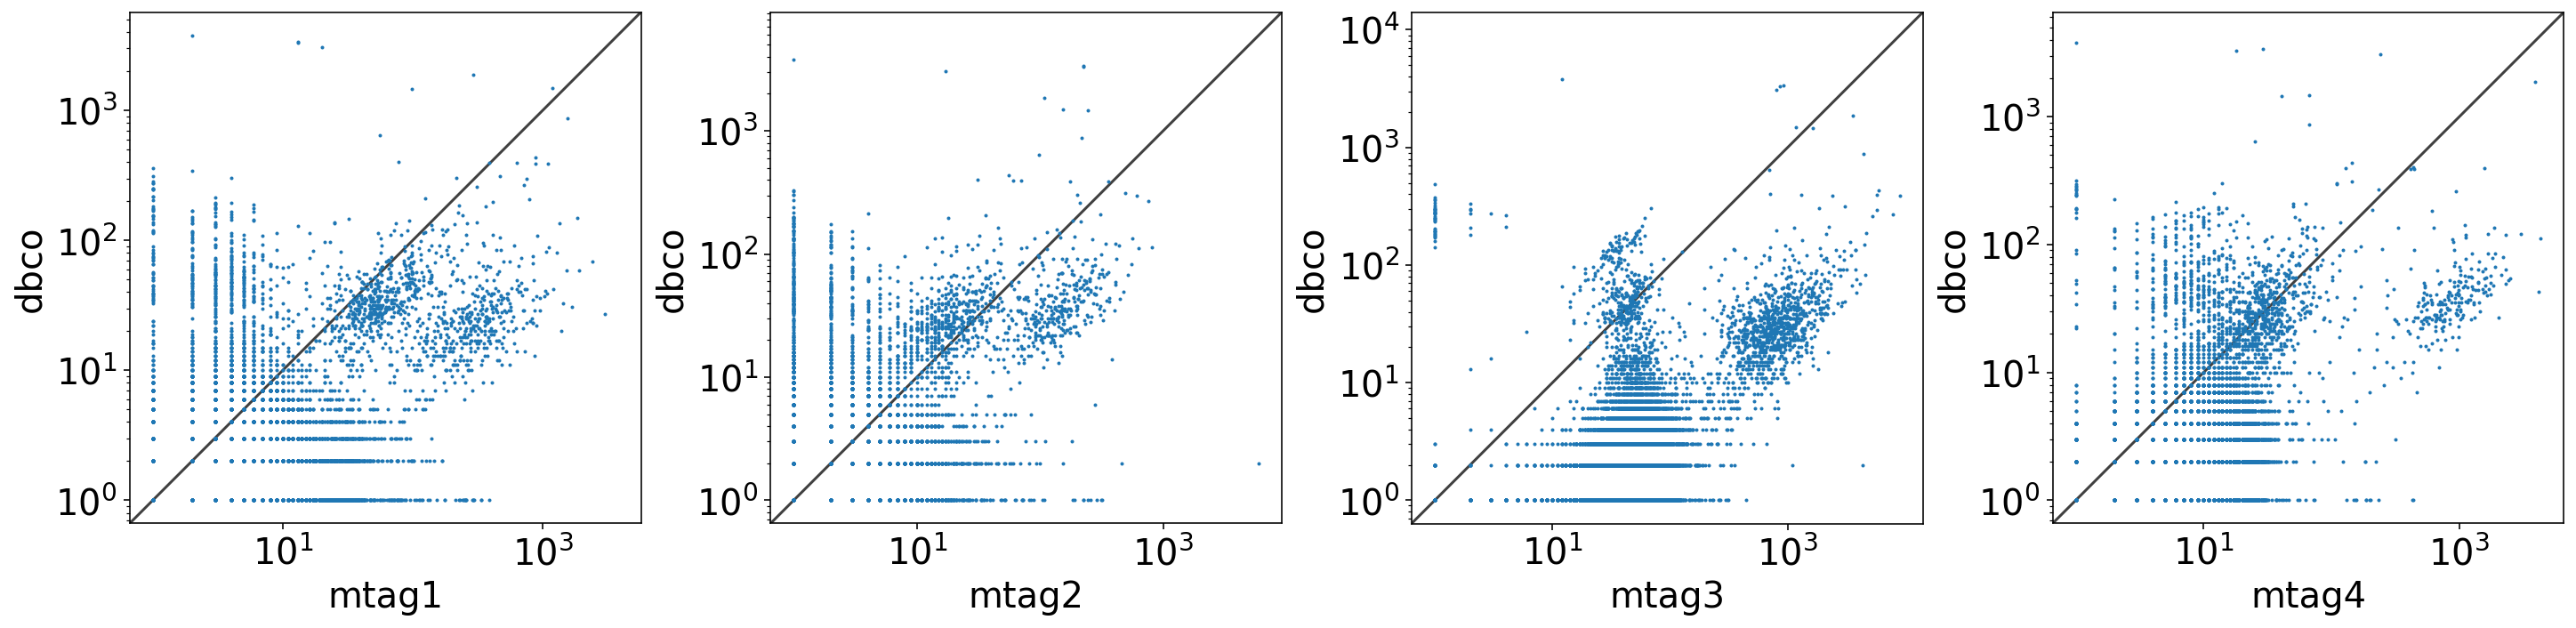

In [7]:
fig, axs = plt.subplots(figsize=(5*4,5), ncols=4, constrained_layout=True)

xidx = 0
yidx = -1 # dbco

dbco = y = adata.X[:,yidx].A.ravel()
Y = adata.X.A.T[:-1]
for xidx, (ax, gvec) in enumerate(zip(axs, Y)):
    ax.scatter(gvec,dbco, s=1)
    ax.set(**{
        "xscale": "log",
        "yscale": "log",
        "xlabel": genes[xidx],
        "ylabel": "dbco",
    })
    yex(ax)
fig.show()

```json
{
    'no_sugar': ['mtag1', 'mtag3'],
    'control':  ['mtag3', 'mtag4'],
    'tmg':      ['mtag2', 'mtag3']
}
 
 ```

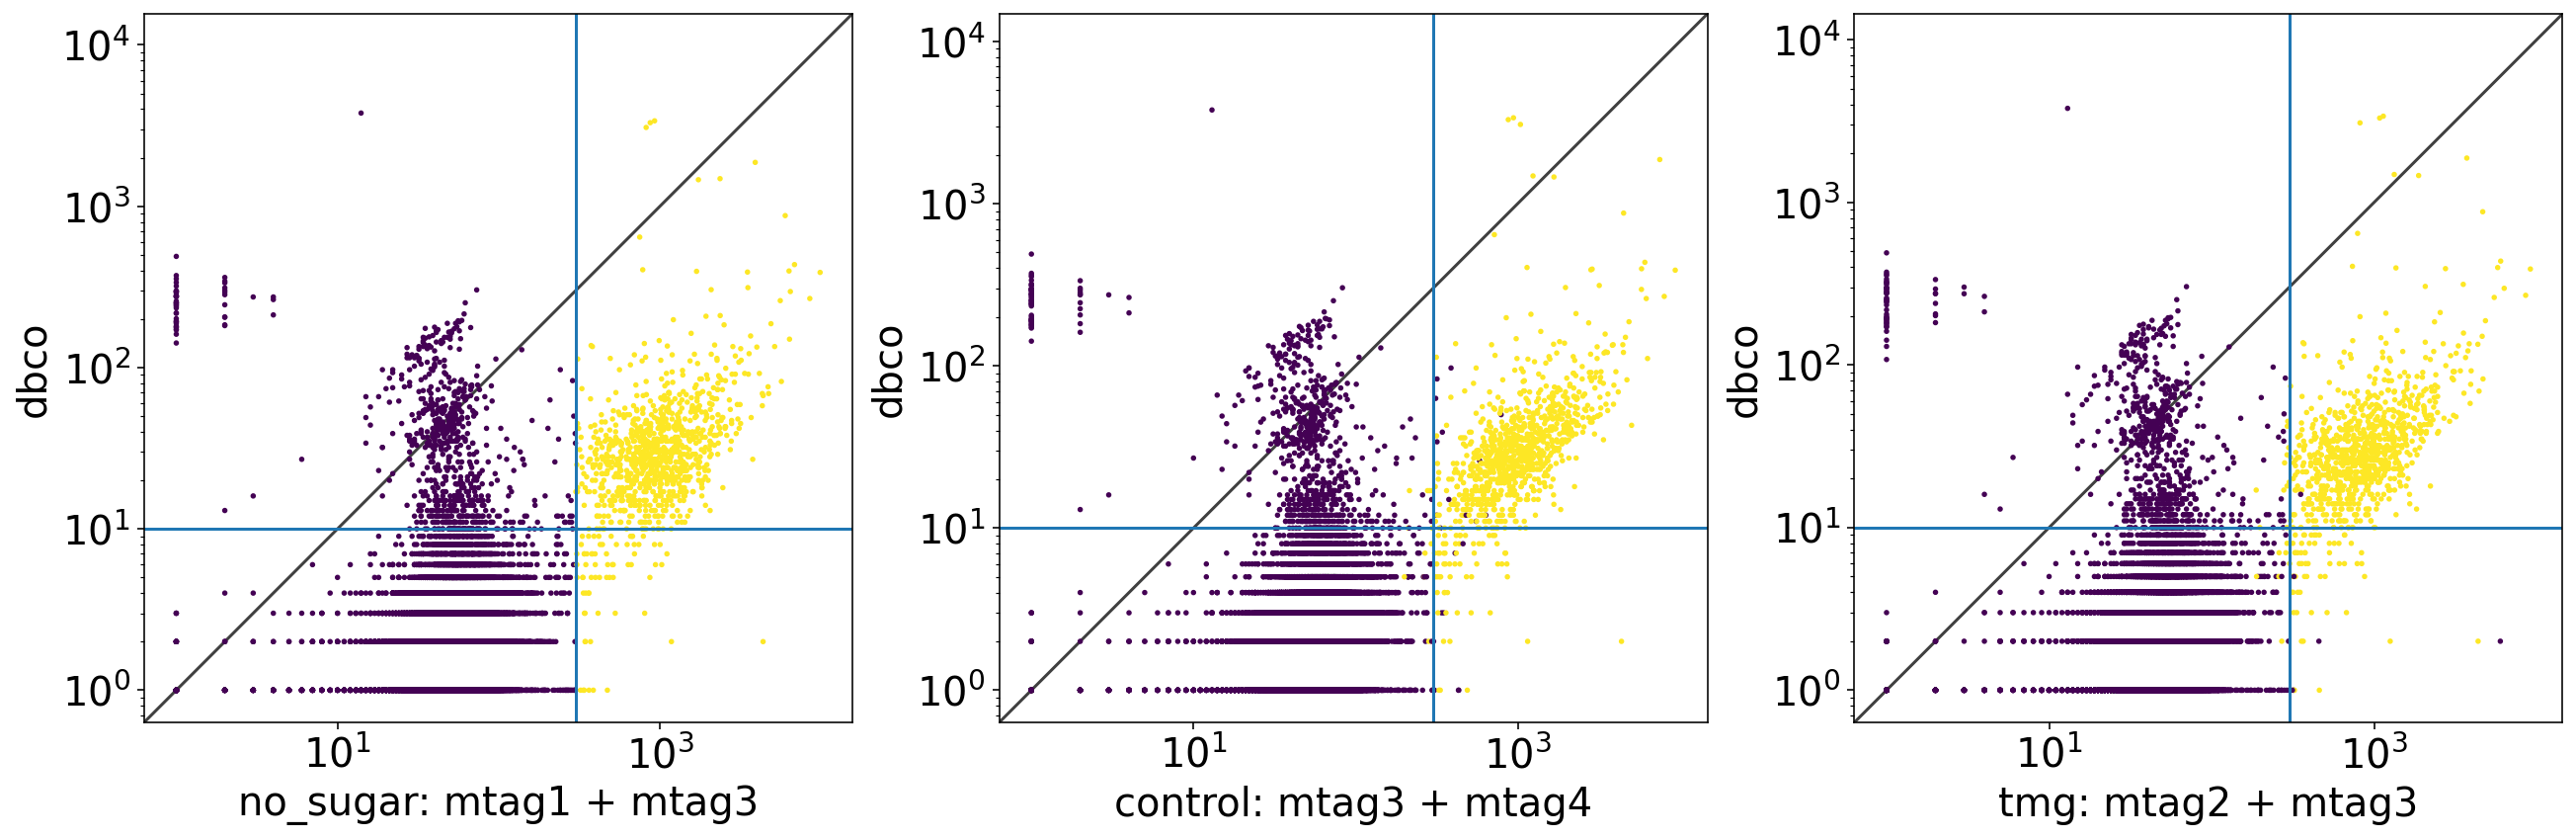

In [8]:
fkwd = {
    "figsize": (
        6*3,
        10
    ), 
    "ncols": 3,
    "constrained_layout": True
}

fig, axs = plt.subplots(**fkwd)

dbco =  adata.X[:,-1].A.ravel()
Y = adata.X.A.T[:-1]
g1v = Y[0]
g3v = Y[2]
m = (g1v + g3v ) > 300
c = m.astype(int)
for ax, (_, (g1, g2)) in zip(axs, markers_ec.items()):
    ax.axhline(10)
    ax.axvline(300)
    ax.scatter(Y[g1] + Y[g2], dbco, s=3, c=c)
    ax.set(**{
        "xscale": "log",
        "yscale": "log",
        "xlabel": f"{groups[_]}: mtag{g1+1} + mtag{g2+1}",
        "ylabel": "dbco",
    })
    yex(ax)
fig.show()

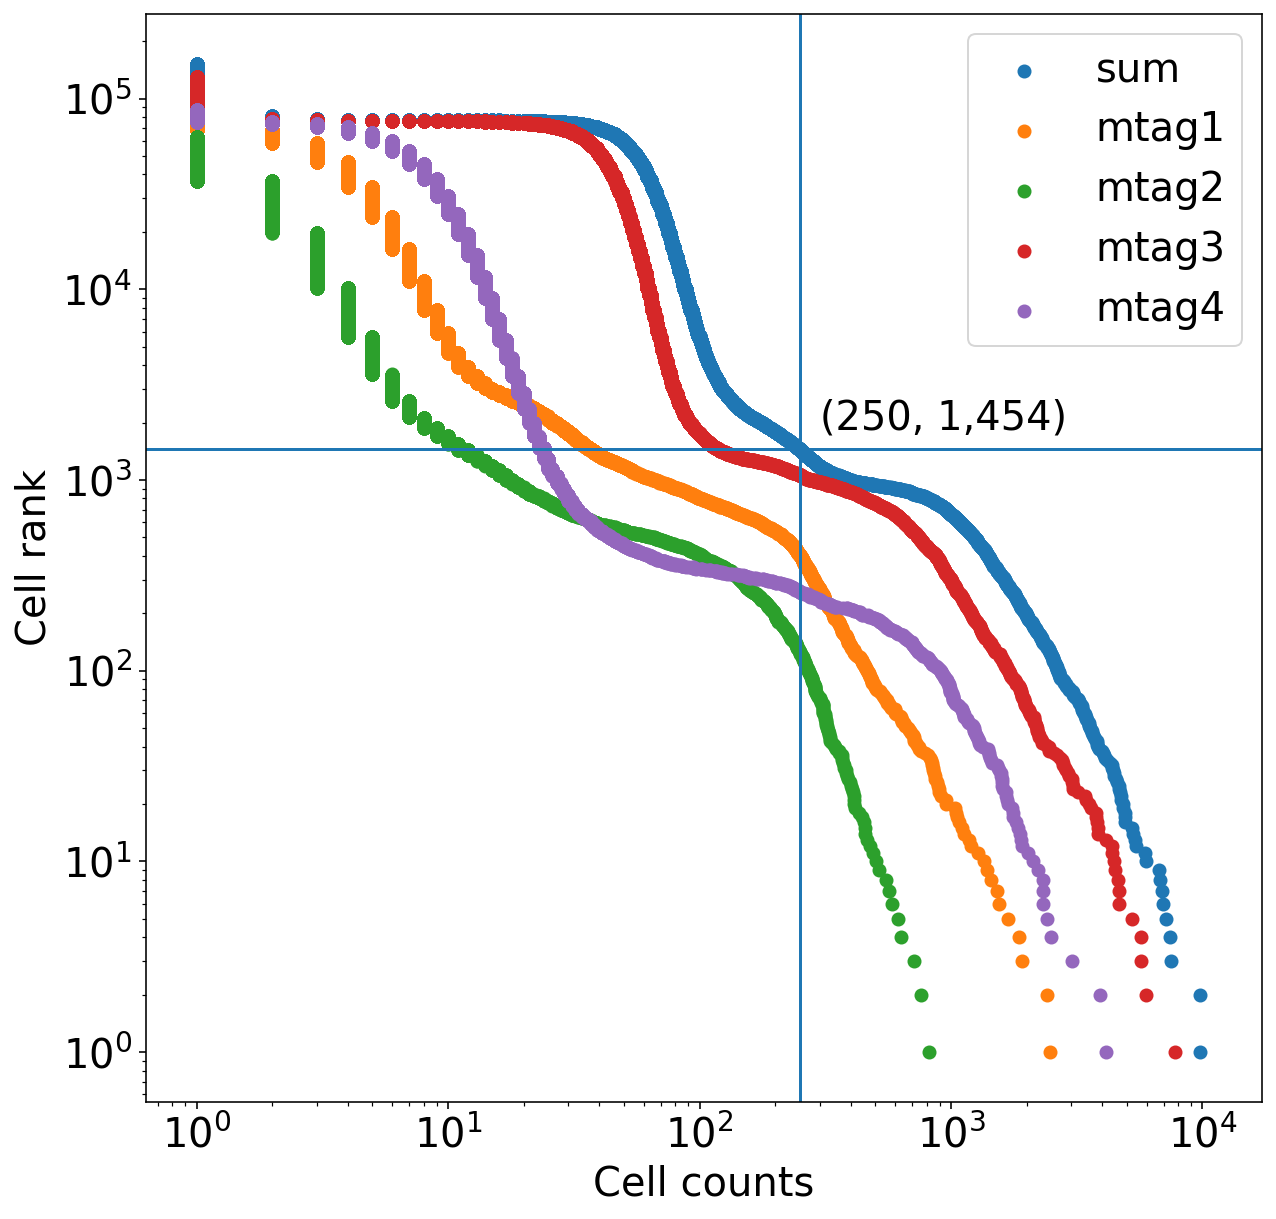

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

x = np.sort(adata.X.sum(1).A.ravel())[::-1]
y = np.arange(x.shape[0])
cut = 250
rank = y[x<cut][0]

ax.axvline(cut)
ax.axhline(rank)
ax.scatter(x,y, label="sum")
ax.annotate(f"({cut:,.0f}, {rank:,.0f})", xy=(cut, rank), xycoords='data',xytext=(10, 10), textcoords='offset points')

## plot all tags
for idx, gvec in enumerate(X.T):

    tag = tags[idx]
    
    x = np.sort(gvec)[::-1]
    y = np.arange(x.shape[0])

    ax.scatter(x, y, label=tag)

ax.set(**{
    "xlabel": "Cell counts",
    "ylabel": "Cell rank",
    "xscale": "log",
    "yscale": "log"
})
ax.legend()
fig.show()

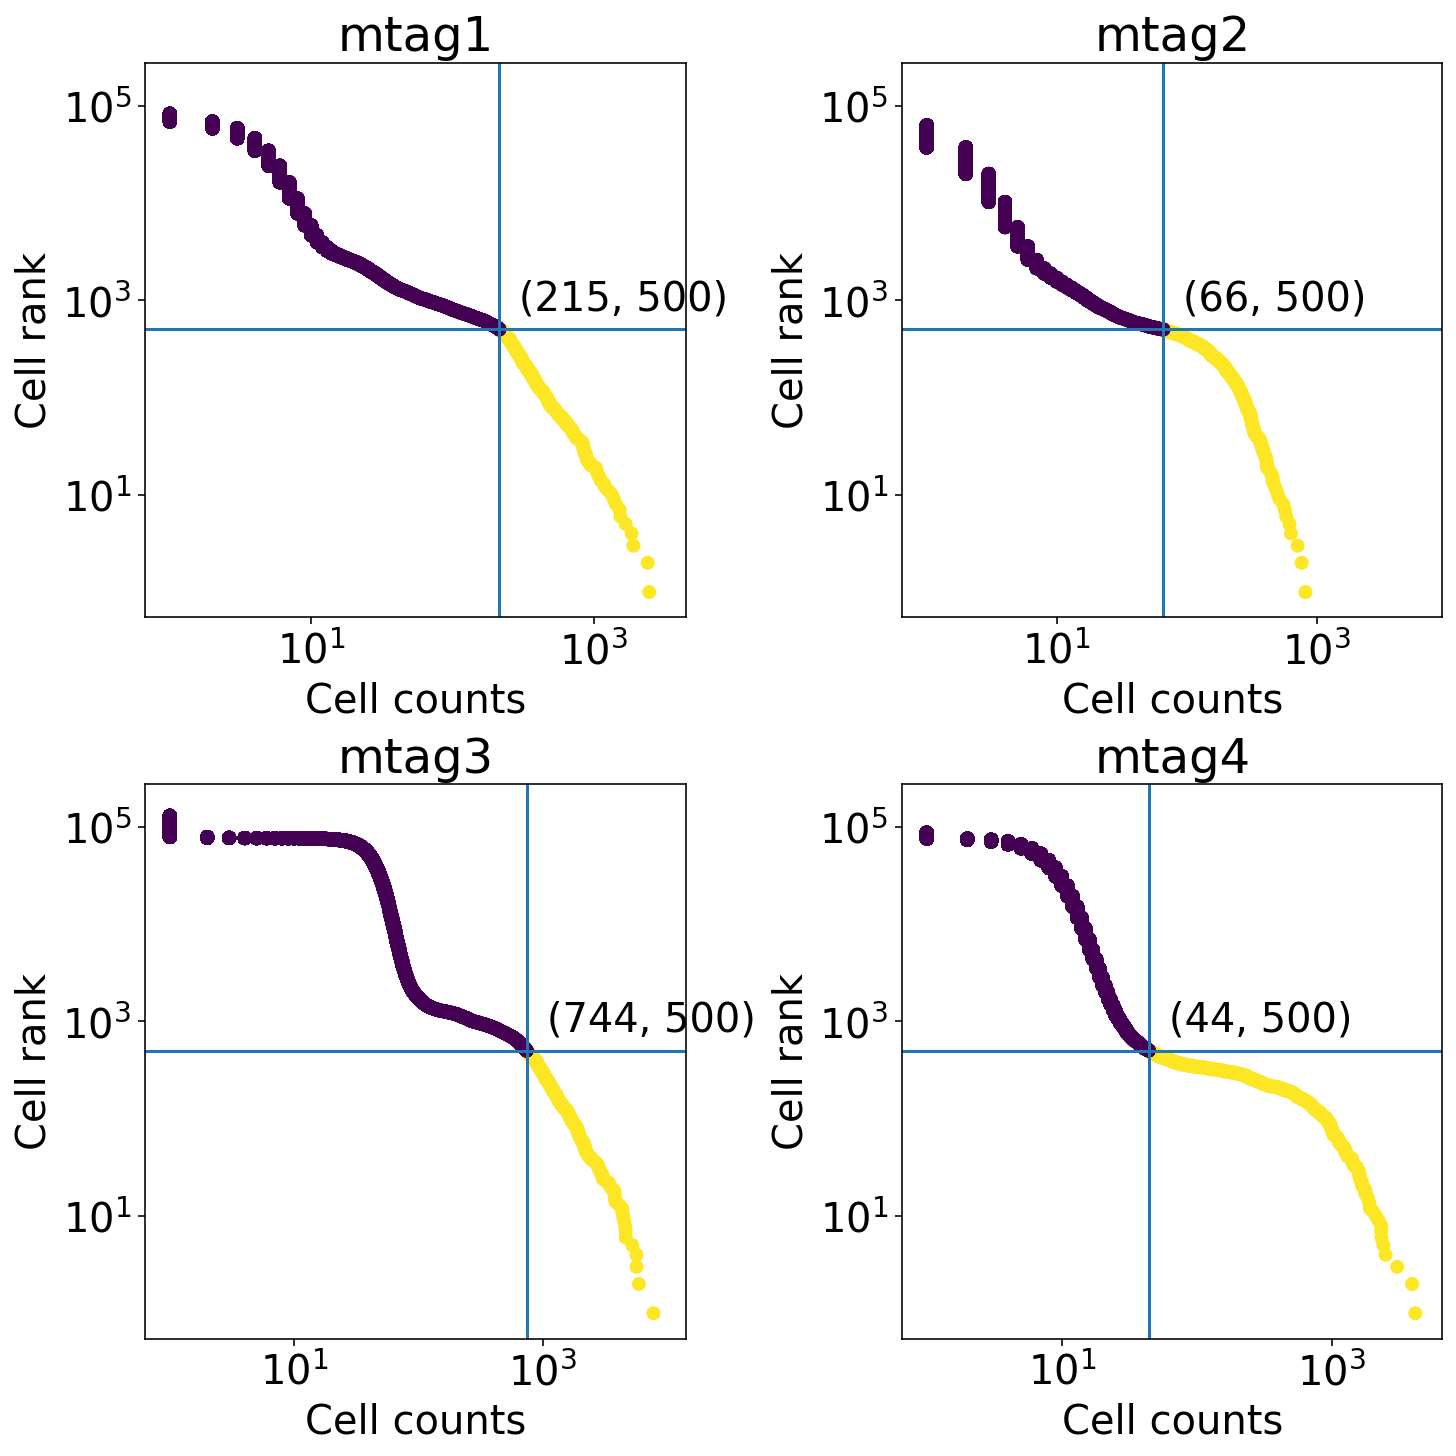

In [10]:
nc = 2
nr = 2

fig, axs = plt.subplots(figsize=(5*nc, 5*nr), ncols=nc, nrows=nr, constrained_layout=True)


## plot all tags
for idx, gvec in enumerate(subset.X.A.T):
    ax = fig.axes[idx]

    tag = tags[idx]
    
    x = np.sort(gvec)[::-1]
    y = np.arange(x.shape[0])
    c = np.zeros_like(x)
    rank = 500
    c[:rank] = 1
    cut = x[rank]

    ax.scatter(x,y, c = c, label=tag)
    ax.axvline(cut)
    ax.axhline(rank)

    ax.annotate(f"({cut:,.0f}, {rank:,.0f})", xy=(cut, rank), xycoords='data',xytext=(10, 10), textcoords='offset points')

    ax.set(**{
        "title": tag,
        "xlabel": "Cell counts",
        "ylabel": "Cell rank",
        "xscale": "log",
        "yscale": "log"
    })


fig.show()    

# need to depth normalize before doing ranking

In [53]:
def filter_highlow(X):
    cellsum = X.sum(1).ravel()
    # get midpoint index
    midx = int(X.shape[0]*0.50)
    print(f"Top {midx:,.0f} of {X.shape[0]:,.0f}")

    # all cells start at zero
    highlow = np.zeros_like(X)

    # for each tag, if the cell is in the high part, set it equal to one
    for idx, r in enumerate(np.argpartition(X.T, midx, axis=1)[:,midx:]):
        highlow[:,idx][r] = 1
    bool_mask = highlow.sum(1) == 2
    return (bool_mask, highlow)

def filter_rank(X, min_rank = 0):
    cellsum = X.sum(1).ravel()
    # get midpoint index
    ranks = rankdata(X, axis=0, method="ordinal")
    m = ranks > min_rank
    bool_mask = np.logical_or.reduce(m, axis=1)
    return (bool_mask, ranks)

In [56]:
bool_mask, ranks = filter_rank(X, min_rank = X.shape[0]*0.99)

In [57]:
bool_mask.sum()

3509

In [15]:
_, highlow = filter_highlow(X)
    
# how many times is a cell in the upper half for a tag?
pd.Series(highlow.sum(1)).value_counts().sort_index()

Top 76,190 of 152,381


0.0    57002
1.0    18467
2.0     2377
3.0    16597
4.0    57938
dtype: int64

In [17]:
(highlow.sum(1)>1).sum()

76912

In [18]:
bool_mask = highlow.sum(1) >= 2

In [19]:
print("Tag\t%>50\tn>50")
for idx, r in enumerate(X.T):
    frac = pd.Series(r[r > 0]).value_counts(normalize=True).sort_index().tail(-50).sum()
    num = pd.Series(r[r > 0]).value_counts(normalize=False).sort_index().tail(-50).sum()
    print(f"{tags[idx]}\t{100*frac:,.2f}\t{num:,.0f}")

Tag	%>50	n>50
mtag1	1.42	1,169
mtag2	0.86	542
mtag3	21.65	28,048
mtag4	0.52	450


In [ ]:
# select the rows where the elements are 

In [512]:
rev_markers_ec = {str(v): k for k, v in markers_ec.items()}

In [548]:
df = pd.Series(
    np.sort(
        np.where(highlow[bool_mask] == 1)[1].reshape(-1, 2),
        axis=1
    ).tolist()
).astype(str)

In [549]:
df.index = df.index.map({k: groups[v] for k,v in rev_markers_ec.items()})

In [560]:
df.index = df.map({k: groups[v] for k,v in rev_markers_ec.items()})

In [572]:
relevant_mask = (~df.reset_index()["index"].isna()).values

```json
{
    'no_sugar': ['mtag1', 'mtag3'],
    'control':  ['mtag3', 'mtag4'],
    'tmg':      ['mtag2', 'mtag3']
}
 
 ```

{'[0, 2]': 0, '[2, 3]': 1, '[1, 2]': 2}

In [507]:
print(markers_ec)
print(groups)

{0: [0, 2], 1: [2, 3], 2: [1, 2]}
['no_sugar', 'control', 'tmg']


In [300]:
bool_mask.sum()

5693

In [163]:
ind_mask = np.logical_or.reduce(([tv > i for tv, i in zip(tagvals, list(cuts.values()))]))
ind_mask.sum()

1344

In [164]:
filter_tag = adata.obs.index.values[ind_mask]

In [19]:
tot_mask = cellsum > 500
tot_mask.sum()

938

In [20]:
filter_sum = adata.obs.index.values[tot_mask]

In [21]:
def diff(A, B):
    left  = np.setdiff1d  (A, B).shape[0]
    itx   = np.intersect1d(A, B).shape[0]
    right = np.setdiff1d  (B, A).shape[0]

    return (left, itx, right)

In [22]:
diff(filter_tag, filter_sum)

(505, 839, 99)

for each tag, we want the highest guys and the lowest guys, but the lowest guys should also be considered high in the combined tag
| 
| |
  |

| |
|

In [58]:
fil = adata[bool_mask]

In [59]:
fil

View of AnnData object with n_obs × n_vars = 3509 × 5

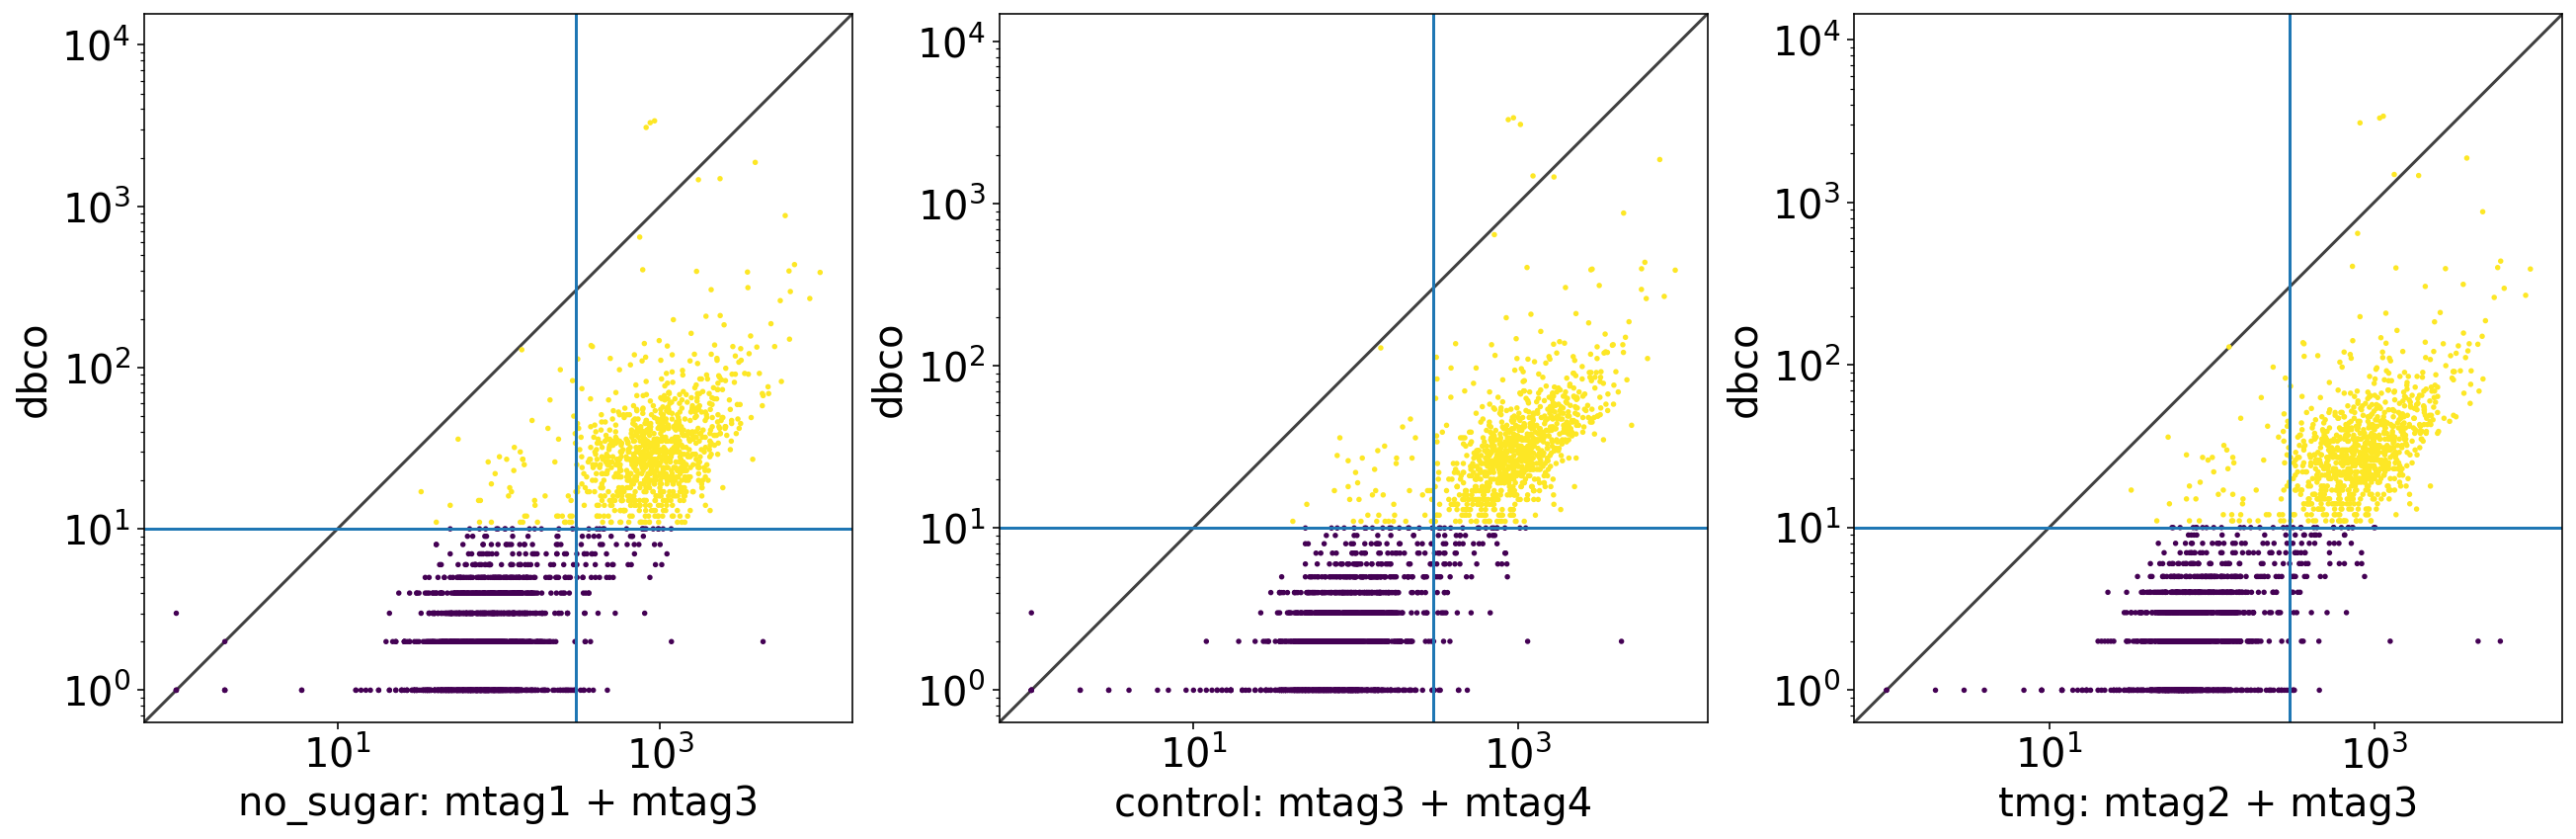

In [60]:
fkwd = {
    "figsize": (
        6*3,
        10
    ), 
    "ncols": 3,
    "constrained_layout": True
}

fig, axs = plt.subplots(**fkwd)

dbco =  fil.X[:,-1].A.ravel()
Y = fil.X.A.T[:-1]
g1v = Y[1]
g3v = Y[2]
c = np.logical_and(dbco > 10, g1v + g3v > 10).astype(int)
# c = m.astype(int)
for ax, (_, (g1, g2)) in zip(axs, markers_ec.items()):
    ax.axhline(10)
    ax.axvline(300)
    ax.scatter(Y[g1] + Y[g2], dbco, s=3, c=c)
    ax.set(**{
        "xscale": "log",
        "yscale": "log",
        "xlabel": f"{groups[_]}: mtag{g1+1} + mtag{g2+1}",
        "ylabel": "dbco",
    })
    yex(ax)
fig.show()

In [61]:
def save_adata_as_files(adata, mtx_path, bcs_path, gene_path):
    bcs = adata.obs
    genes = adata.var
    mtx = adata.X
    
    # save mtx
    mmwrite(mtx_path, mtx)
    
    # save barcodes
    bcs.to_csv(bcs_path, header=False, sep="\t", compression="gzip")
    
    # save genes
    genes.to_csv(gene_path, header=False, sep="\t", compression="gzip")

In [62]:
save_adata_as_files(fil, out_matrix_fn, out_barcodes_fn, out_genes_fn)
!gzip -f $out_matrix_fn

In [578]:
out_matrix_fn

'azucar/data/293T/obs2/matrix.mtx'

In [32]:
!ls -lht azucar/data/293T/obs2/

total 204K
-rw-rw-r-- 1 sina sina 6.4K Apr 11 16:54 barcodes.txt.gz
-rw-rw-r-- 1 sina sina   57 Apr 11 16:54 genes.txt.gz
-rw-rw-r-- 1 sina sina  24K Apr 11 16:54 matrix.mtx.gz
drwxrwxr-x 2 sina sina 4.0K Apr 11 16:28 fastqs
-rw-rw-r-- 1 sina sina  598 Feb 14 16:40 run_info.json
-rw-rw-r-- 1 sina sina  588 Feb 14 16:40 inspect.json
-rw-rw-r-- 1 sina sina 3.8K Feb 14 16:40 kb_info.json
-rw-rw-r-- 1 sina sina  152 Feb  3 10:43 metadata.json
-rw-rw-r-- 1 sina sina  76K Oct  2  2021 fastqc_data.txt
-rw-rw-r-- 1 sina sina  64K Oct  2  2021 fastqc_report.html
-rw-rw-r-- 1 sina sina  727 Oct  2  2021 summary.txt
drwxrwxr-x 4 sina sina 4.0K Sep 30  2021 tags_out


In [ ]:
\